In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
# import ray
# ray.init(num_cpus=4)
# import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import gc
import category_encoders as ce

from utils.schemas import *
from utils.functions import *

In [3]:
data_folder = 'input'

In [4]:
train = pd.read_csv(data_folder+'/train_synthetic_1.csv', dtype = schema_synthetic_1)#.sort_values('TransactionDT')
test = pd.read_csv(data_folder+'/test_synthetic_1.csv', dtype = schema_synthetic_1)#.sort_values('TransactionDT')

In [5]:
train.shape, test.shape

((270901, 536), (221908, 536))

In [6]:
train_index = train.shape[0]
test_index = test.shape[0]
df = pd.concat([train, test], axis=0)
df.shape

(492809, 536)

In [7]:
old_cols = df.columns

In [7]:
# pd.options.display.max_rows=500

In [8]:
df.ProductCD.unique()

array([0, 3, 1, 4, 2], dtype=uint64)

In [9]:
# a = ['M{}'.format(i) for i in range(1,10)]

In [10]:
# train['day'] = np.floor(train['TransactionDT'] / (3600 * 24) - 1)

In [11]:
train['M'] = train.M1.astype(str) + train.M2.astype(str) + train.M3.astype(str) +\
train.M4.astype(str) + train.M5.astype(str) + train.M6.astype(str) + \
train.M7.astype(str) + train.M8.astype(str) + train.M9.astype(str)

test['M'] = test.M1.astype(str) + test.M2.astype(str) + test.M3.astype(str) +\
test.M4.astype(str) + test.M5.astype(str) + test.M6.astype(str) + \
test.M7.astype(str) + test.M8.astype(str) + test.M9.astype(str)

In [9]:
df['M'] = df.M1.astype(str) + df.M2.astype(str) + df.M3.astype(str) +\
df.M4.astype(str) + df.M5.astype(str) + df.M6.astype(str) + \
df.M7.astype(str) + df.M8.astype(str) + df.M9.astype(str)

In [12]:
train = train.drop(['D9'],axis=1)

test = test.drop(['D9'],axis=1)

In [10]:
df = df.drop(['D9'],axis=1)

In [13]:
train['card'] = train.card1.astype(str) + train.card2.astype(str) + train.card3.astype(str) +\
train.card4.astype(str) + train.card5.astype(str) + train.card6.astype(str)

test['card'] = test.card1.astype(str) + test.card2.astype(str) + test.card3.astype(str) +\
test.card4.astype(str) + test.card5.astype(str) + test.card6.astype(str)

In [11]:
df['card'] = df.card1.astype(str) + df.card2.astype(str) + df.card3.astype(str) +\
df.card4.astype(str) + df.card5.astype(str) + df.card6.astype(str)

In [14]:
train['email'] = train.P_emaildomain.astype(str) + train.R_emaildomain.astype(str)

test['email'] = test.P_emaildomain.astype(str) + test.R_emaildomain.astype(str)

In [12]:
df['email'] = df.P_emaildomain.astype(str) + df.R_emaildomain.astype(str)

In [15]:
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24

test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

In [13]:
df['Transaction_day_of_week'] = np.floor((df['TransactionDT'] / (3600 * 24) - 1) % 7)
df['Transaction_hour'] = np.floor(df['TransactionDT'] / 3600) % 24

Binary encoder

In [14]:
binary_cat_ft = ['card', 'M', 'email', 'Transaction_day_of_week', 'Transaction_hour', 'DeviceType', 'proc_id_30_0',
                 'proc_id_30_1', 'proc_id_31_0']

In [18]:
encoder = ce.BinaryEncoder(cols=binary_cat_ft)
encoder.fit(train)
train = encoder.transform(train)
test = encoder.transform(test)

In [15]:
encoder = ce.BinaryEncoder(cols=binary_cat_ft)
df = encoder.fit_transform(df)

In [43]:
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24

test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

In [16]:
df['Transaction_day_of_week'] = np.floor((df['TransactionDT'] / (3600 * 24) - 1) % 7)
df['Transaction_hour'] = np.floor(df['TransactionDT'] / 3600) % 24

In [18]:
def freq_encoder2(df, label, min_freq = 0.001):
    rows = df.shape[0]
    n = 0
    dict_fe = dict()
    vc = df[label].value_counts()
    for i, j in zip(vc.index, vc):
        ratio = j/rows
        if ratio > min_freq:
            dict_fe[i] = n
            n += 1
        else:
            dict_fe[i] = n
        
    if n < 2**8:
        _d_type = 'uint8'
    elif n >= 2**8 and n < 8**16:
        _d_type = 'uint16'
    elif n >= 2**16 and n < 8**32:
        _d_type = 'uint32'
    else:
        _d_type = 'uint64'
        
#     df[new_label] = df[label].apply(lambda x: dict_fe[x]).astype(_d_type)
    
    return dict_fe, _d_type

In [19]:
dict_fe, _d_type = freq_encoder2(df, 'Transaction_day_of_week', 0)
df['Transaction_day_of_week'] = df['Transaction_day_of_week'].apply(lambda x: dict_fe[x]).astype(_d_type)

dict_fe, _d_type = freq_encoder2(df, 'Transaction_hour', 0)
df['Transaction_hour'] = df['Transaction_hour'].apply(lambda x: dict_fe[x]).astype(_d_type)

In [20]:
df.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,Transaction_day_of_week_2,Transaction_day_of_week_3,Transaction_hour_0,Transaction_hour_1,Transaction_hour_2,Transaction_hour_3,Transaction_hour_4,Transaction_hour_5,Transaction_day_of_week,Transaction_hour
0,0,86400,68.5,0,1572,12,0,3,30,1,...,0,1,0,0,0,0,0,1,0,8
1,0,86401,29.0,0,152,36,0,1,3,1,...,0,1,0,0,0,0,0,1,0,8
2,0,86469,59.0,0,95,3,0,0,2,0,...,0,1,0,0,0,0,0,1,0,8
3,0,86499,50.0,0,15,21,0,1,4,0,...,0,1,0,0,0,0,0,1,0,8
4,0,86506,50.0,3,2995,8,0,1,3,1,...,0,1,0,0,0,0,0,1,0,8


In [19]:
# train[(train.card1 == 0) & (train.addr1 == 1) & (train.addr2 == 0)
#      & (train.card2 == 6) & (train.P_emaildomain == 0)]\
# [['ProductCD','addr1','addr2','card1','card2','card3','card4','card5','P_emaildomain','TransactionAmt','R_emaildomain','TransactionDT','D9','Transaction_hour','day','M','card','isFraud']]\
# .set_index(['M','addr1','addr2','card1','card2','card3','card4','card5','P_emaildomain','TransactionDT'])

In [20]:
# train[(train.card1 == 0) & (train.addr1 == 1) & (train.addr2 == 0)
#      & (train.card2 == 6) & (train.P_emaildomain == 0) & (train.ProductCD == 0)]\
# [['ProductCD','addr1','addr2','card1','card2','card3','card4','card5','P_emaildomain','R_emaildomain','TransactionDT','M','isFraud']]\
# .set_index(['ProductCD','M'])

In [21]:
# del train
# del test
# gc.collect()

In [21]:
id_cols = ['addr1', 'addr2', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'P_emaildomain']

In [22]:
# train.head()

In [23]:
gc.collect()

112

In [24]:
def plot_col(df, col):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 6)
    ax.plot(df[df.isFraud == 0].TransactionDT, df[df.isFraud == 0][col])
    ax.plot(df[df.isFraud == 1].TransactionDT, df[df.isFraud == 1][col])
    ax.plot(df[df.isFraud.isna()].TransactionDT, df[df.isFraud.isna()][col])
    plt.show()
    gc.collect()

In [25]:
def plot_hist_col(df, col):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 6)
    ax.hist(df[df.isFraud.isna()][col], 100)
    ax.hist(df[df.isFraud == 0][col], 100)
    ax.hist(df[df.isFraud == 1][col], 100)
    plt.show()
    gc.collect()

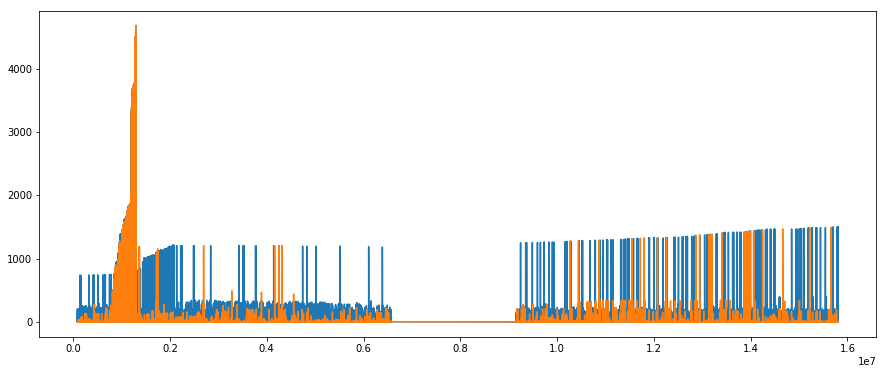

In [29]:
plot_col(df, 'C1')

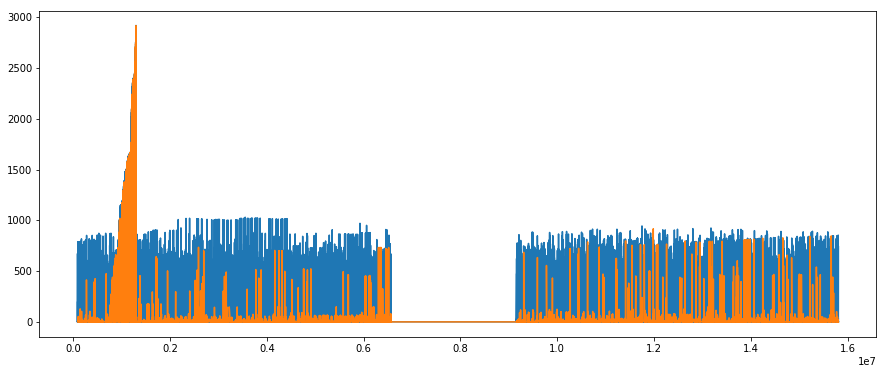

In [28]:
plot_col(df, 'C13')

In [28]:
def freq_encoder2(df, label, min_freq = 0.001):
    rows = df.shape[0]
    n = 0
    dict_fe = dict()
    vc = df[label].value_counts()
    for i, j in zip(vc.index, vc):
        ratio = j/rows
        if ratio > min_freq:
            dict_fe[i] = n
            n += 1
        else:
            dict_fe[i] = n

    if n < 2**8:
        _d_type = 'uint8'
    elif n >= 2**8 and n < 8**16:
        _d_type = 'uint16'
    elif n >= 2**16 and n < 8**32:
        _d_type = 'uint32'
    else:
        _d_type = 'uint64'

#     df[new_label] = df[label].apply(lambda x: dict_fe[x]).astype(_d_type)

    return dict_fe, _d_type

def freq_encoder2_test(df, label, dict_fe):
    list_unique = df[label].unique()
    max_val = max(dict_fe.values())
    train_values = dict_fe.keys()
    for v in list_unique:
        if v not in train_values:
            dict_fe[v] = max_val+1
    
    return dict_fe

In [36]:
cols1 = [x for x in train.columns if 'card' in x and '_fe1' in x]

In [30]:
cols1 = [x for x in train.columns if 'card' in x and '_fe1' in x]
ft = 'N1'
train[ft] = train.groupby(cols1)['TransactionDT'].transform('count')
test[ft] = test.groupby(cols1)['TransactionDT'].transform('count')
# dict_fe, _d_type = freq_encoder2(train, ft, 0)
# dict_fe_test = freq_encoder2_test(test, ft, dict_fe)
# train[ft] = train[ft].apply(lambda x: dict_fe[x]).astype(_d_type)
# test[ft] = test[ft].apply(lambda x: dict_fe_test[x]).astype(_d_type)

cols1 = ['addr1', 'addr2']
ft = 'N2'
train[ft] = train.groupby(cols1)['TransactionDT'].transform('count')
test[ft] = test.groupby(cols1)['TransactionDT'].transform('count')

cols1 = [x for x in train.columns if 'C' in x and 'Product' not in x]
ft = 'N3'
train[ft] = train.groupby(cols1)['TransactionDT'].transform('count')
test[ft] = test.groupby(cols1)['TransactionDT'].transform('count')

cols1 = [x for x in train.columns if 'mail' in x]
ft = 'N4'
train[ft] = train.groupby(cols1)['TransactionDT'].transform('count')
test[ft] = test.groupby(cols1)['TransactionDT'].transform('count')

cols1 = ['P_emaildomain', 'R_emaildomain', 'addr1']
ft = 'N5'
train[ft] = train.groupby(cols1)['TransactionDT'].transform('count')
test[ft] = test.groupby(cols1)['TransactionDT'].transform('count')

cols1 = ['P_emaildomain', 'R_emaildomain', 'addr1', 'card1']
ft = 'N6'
train[ft] = train.groupby(cols1)['TransactionDT'].transform('count')
test[ft] = test.groupby(cols1)['TransactionDT'].transform('count')

cols1 = ['addr1', 'addr2', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'P_emaildomain']
ft = 'N7'
train[ft] = train.groupby(cols1)['TransactionDT'].transform('count')
test[ft] = test.groupby(cols1)['TransactionDT'].transform('count')

In [30]:
cols1 = [x for x in df.columns if 'card' in x and '_fe1' in x]
ft = 'N1'
df[ft] = df.groupby(cols1)['TransactionDT'].transform('count')
dict_fe, _d_type = freq_encoder2(df, ft, min_freq = 0)
df[ft] = df[ft].apply(lambda x: dict_fe[x]).astype(_d_type)

cols1 = ['addr1', 'addr2']
ft = 'N2'
df[ft] = df.groupby(cols1)['TransactionDT'].transform('count')
dict_fe, _d_type = freq_encoder2(df, ft, min_freq = 0)
df[ft] = df[ft].apply(lambda x: dict_fe[x]).astype(_d_type)

cols1 = [x for x in df.columns if 'C' in x and 'Product' not in x]
ft = 'N3'
df[ft] = df.groupby(cols1)['TransactionDT'].transform('count')
dict_fe, _d_type = freq_encoder2(df, ft, min_freq = 0)
df[ft] = df[ft].apply(lambda x: dict_fe[x]).astype(_d_type)

cols1 = [x for x in df.columns if 'mail' in x]
ft = 'N4'
df[ft] = df.groupby(cols1)['TransactionDT'].transform('count')
dict_fe, _d_type = freq_encoder2(df, ft, min_freq = 0)
df[ft] = df[ft].apply(lambda x: dict_fe[x]).astype(_d_type)

cols1 = ['P_emaildomain', 'R_emaildomain', 'addr1']
ft = 'N5'
df[ft] = df.groupby(cols1)['TransactionDT'].transform('count')
dict_fe, _d_type = freq_encoder2(df, ft, min_freq = 0)
df[ft] = df[ft].apply(lambda x: dict_fe[x]).astype(_d_type)


cols1 = ['addr1', 'addr2', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'P_emaildomain']
ft = 'N6'
df[ft] = df.groupby(cols1)['TransactionDT'].transform('count')
dict_fe, _d_type = freq_encoder2(df, ft, min_freq = 0)
df[ft] = df[ft].apply(lambda x: dict_fe[x]).astype(_d_type)

#### V columns

In [37]:
# groups V
cols1 = ['V{}'.format(x) for x in range(1,12)]
cols2 = ['V{}'.format(x) for x in range(12,35)]
cols3 = ['V{}'.format(x) for x in range(35,53)]
cols4 = ['V{}'.format(x) for x in range(53,75)]
cols5 = ['V{}'.format(x) for x in range(75,95)]
cols6 = ['V{}'.format(x) for x in range(95,138)]
cols7 = ['V{}'.format(x) for x in range(138,167)]
cols8 = ['V{}'.format(x) for x in range(167,217)]
cols9 = ['V{}'.format(x) for x in range(217,279)]
cols10 = ['V{}'.format(x) for x in range(279,322)]
cols11 = ['V{}'.format(x) for x in range(322,340)]

In [38]:
# Binary V
bin_v = ['V1', 'V14', 'V41', 'V65', 'V88', 'V107', 'V305']

In [39]:
V_cols = [cols1, cols2, cols3, cols4, cols5, cols6, cols7, cols8, cols9, cols10, cols11, bin_v]

In [40]:
train['N8'] = train.groupby(cols1)['TransactionDT'].transform('count')
train['N8'] = (train.N8/train.N8.max()).astype(np.float32).replace(np.inf, np.nan)
train['N9'] = train.groupby(cols2)['TransactionDT'].transform('count')
train['N9'] = (train.N9/train.N9.max()).astype(np.float32).replace(np.inf, np.nan)
train['N10'] = train.groupby(cols3)['TransactionDT'].transform('count')
train['N10'] = (train.N10/train.N10.max()).astype(np.float32).replace(np.inf, np.nan)
train['N11'] = train.groupby(cols4)['TransactionDT'].transform('count')
train['N11'] = (train.N11/train.N11.max()).astype(np.float32).replace(np.inf, np.nan)
train['N12'] = train.groupby(cols5)['TransactionDT'].transform('count')
train['N12'] = (train.N12/train.N12.max()).astype(np.float32).replace(np.inf, np.nan)
train['N13'] = train.groupby(cols6)['TransactionDT'].transform('count')
train['N13'] = (train.N13/train.N13.max()).astype(np.float32).replace(np.inf, np.nan)
train['N14'] = train.groupby(cols7)['TransactionDT'].transform('count')
train['N14'] = (train.N14/train.N14.max()).astype(np.float32).replace(np.inf, np.nan)
train['N15'] = train.groupby(cols8)['TransactionDT'].transform('count')
train['N15'] = (train.N15/train.N15.max()).astype(np.float32).replace(np.inf, np.nan)
train['N16'] = train.groupby(cols9)['TransactionDT'].transform('count')
train['N16'] = (train.N16/train.N16.max()).astype(np.float32).replace(np.inf, np.nan)
train['N17'] = train.groupby(cols10)['TransactionDT'].transform('count')
train['N17'] = (train.N17/train.N17.max()).astype(np.float32).replace(np.inf, np.nan)
train['N18'] = train.groupby(cols11)['TransactionDT'].transform('count')
train['N18'] = (train.N18/train.N18.max()).astype(np.float32).replace(np.inf, np.nan)
train['N19'] = train.groupby(bin_v)['TransactionDT'].transform('count')
train['N19'] = (train.N19/train.N19.max()).astype(np.float32).replace(np.inf, np.nan)
n = 20
for c in V_cols[:4]:
    train['N{}'.format(n)] = (train.groupby(c)['TransactionDT'].transform('std')/train.groupby(c)['TransactionDT'].transform('mean')).replace(np.inf, np.nan)
    n += 1
    
test['N8'] = test.groupby(cols1)['TransactionDT'].transform('count')
test['N8'] = (test.N8/test.N8.max()).astype(np.float32).replace(np.inf, np.nan)
test['N9'] = test.groupby(cols2)['TransactionDT'].transform('count')
test['N9'] = (test.N9/test.N9.max()).astype(np.float32).replace(np.inf, np.nan)
test['N10'] = test.groupby(cols3)['TransactionDT'].transform('count')
test['N10'] = (test.N10/test.N10.max()).astype(np.float32).replace(np.inf, np.nan)
test['N11'] = test.groupby(cols4)['TransactionDT'].transform('count')
test['N11'] = (test.N11/test.N11.max()).astype(np.float32).replace(np.inf, np.nan)
test['N12'] = test.groupby(cols5)['TransactionDT'].transform('count')
test['N12'] = (test.N12/test.N12.max()).astype(np.float32).replace(np.inf, np.nan)
test['N13'] = test.groupby(cols6)['TransactionDT'].transform('count')
test['N13'] = (test.N13/test.N13.max()).astype(np.float32).replace(np.inf, np.nan)
test['N14'] = test.groupby(cols7)['TransactionDT'].transform('count')
test['N14'] = (test.N14/test.N14.max()).astype(np.float32).replace(np.inf, np.nan)
test['N15'] = test.groupby(cols8)['TransactionDT'].transform('count')
test['N15'] = (test.N15/test.N15.max()).astype(np.float32).replace(np.inf, np.nan)
test['N16'] = test.groupby(cols9)['TransactionDT'].transform('count')
test['N16'] = (test.N16/test.N16.max()).astype(np.float32).replace(np.inf, np.nan)
test['N17'] = test.groupby(cols10)['TransactionDT'].transform('count')
test['N17'] = (test.N17/test.N17.max()).astype(np.float32).replace(np.inf, np.nan)
test['N18'] = test.groupby(cols11)['TransactionDT'].transform('count')
test['N18'] = (test.N18/test.N18.max()).astype(np.float32).replace(np.inf, np.nan)
test['N19'] = test.groupby(bin_v)['TransactionDT'].transform('count')
test['N19'] = (test.N19/test.N19.max()).astype(np.float32).replace(np.inf, np.nan)
n = 20
for c in V_cols[:4]:
    test['N{}'.format(n)] = (test.groupby(c)['TransactionDT'].transform('std')/test.groupby(c)['TransactionDT'].transform('mean')).replace(np.inf, np.nan)
    n += 1
gc.collect()

2575

New features

In [41]:
c_cols = [x for x in train.columns if 'C' in x and x not in ['ProductCD','ProductCD_fe1','ProductCD_fe2']]

In [44]:
train['R1'] = (np.log1p(train.C13/train.C1)).replace(np.inf, np.nan)

train['R2'] = (np.log1p(train.D1/train.D15)).replace(np.inf, np.nan)

train['R3'] = (np.log1p(train.TransactionAmt/train.TransactionAmt.values.mean())).replace(np.inf, np.nan)

train['R4'] = (np.log1p(train.N3/train.N1)).replace(np.inf, np.nan)

train['R5'] = (train['D15'] / train.groupby(['card1', 'addr1'])['D15'].transform('std')).replace(np.inf, np.nan)

train['R6'] = (train['D15'] / train.groupby(['TransactionDT'])['D15'].transform('std')).replace(np.inf, np.nan)

train['R7'] = (train.TransactionAmt / train.Transaction_hour / train.Transaction_day_of_week).replace(np.inf, np.nan)

train['R8'] = (train['TransactionAmt'] / train.groupby(['card1', 'addr1'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

train['R9'] = (train['TransactionAmt'] / train.groupby(['card1','C13','C1','card2','addr1'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

train['R10'] = (train['TransactionAmt'] / train.groupby(['card1','addr1','id_01','V258','D1', 'P_emaildomain', 'R_emaildomain'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

train['R11'] = (train['TransactionAmt'] / train.groupby(['card1','addr1','P_emaildomain', 'R_emaildomain'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

train['R12'] = (train.groupby(['card1','addr1'])['card1'].transform('mean') * train.groupby(['card1','addr1'])['card1'].transform('count')).replace(np.inf, np.nan)

train['R13'] = (train.TransactionAmt / train.groupby(['card1', 'card2','addr1'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

train['R14'] = (train.C2 / train.groupby(['card1', 'V258', 'D10'])['C2'].transform('mean')).replace(np.inf, np.nan)

train['R15'] = (train.V130 / train.groupby(['addr1', 'card1', 'C10', 'Transaction_hour', 'Transaction_day_of_week'])['V130'].transform('std')).replace(np.inf, np.nan)

train['R16'] = (train.V258 / train.groupby(['addr1', 'card1', 'C10', 'Transaction_hour', 'Transaction_day_of_week'])['V258'].transform('std')).replace(np.inf, np.nan)

train['R17'] = (train.D10 / train.groupby(id_cols)['D10'].transform('std')).replace(np.inf, np.nan)

train['R18'] = (train.D11 / train.groupby(id_cols)['D11'].transform('std')).replace(np.inf, np.nan)

train['R19'] = (train.D15 / train.groupby(id_cols)['D15'].transform('std')).replace(np.inf, np.nan)

train['R20'] = (train.D3 / train.groupby(id_cols)['D3'].transform('std')).replace(np.inf, np.nan)

train['R21'] = (train.D4 / train.groupby(id_cols)['D4'].transform('std')).replace(np.inf, np.nan)

train['R22'] = (train.D5 / train.groupby(id_cols)['D5'].transform('std')).replace(np.inf, np.nan)

train['R23'] = (train.D6 / train.groupby(id_cols)['D6'].transform('std')).replace(np.inf, np.nan)

train['R24'] = train.D7 * train.groupby(id_cols)['D7'].transform('std')
train['R24'] = train['R24'].replace(np.inf, np.nan)
train['R24'] = train['R24']/train['R24'].max()

train['R25'] = train.D12 * train.groupby(id_cols)['D12'].transform('std')
train['R25'] = train['R25'].replace(np.inf, np.nan)
train['R25'] = train['R25']/train['R25'].max()

train['R26'] = train.D6 * train.groupby(id_cols)['D6'].transform('std')
train['R26'] = train['R26'].replace(np.inf, np.nan)
train['R26'] = train['R26']/train['R26'].max()

train['R27'] = train.D8 * train.groupby(id_cols)['D8'].transform('std')
train['R27'] = train['R27'].replace(np.inf, np.nan)
train['R27'] = train['R27']/train['R27'].max()

train['R28'] = (train.TransactionAmt - train.groupby(id_cols)['TransactionAmt'].shift(1)).replace(np.inf, np.nan)

train['R29'] = (train.TransactionDT - (train.TransactionDT - train.groupby(id_cols)['TransactionDT'].shift(1))).replace(np.inf, np.nan)

train['R30'] = (train.dist1 - train.groupby(id_cols)['dist1'].shift(1)).replace(np.inf, np.nan)

train['R31'] = (train.dist2 - train.groupby(id_cols)['dist2'].shift(1)).replace(np.inf, np.nan)

n = 32
for c in c_cols:
    train['R{}'.format(n)] = (train[c] / train.groupby(id_cols)[c].transform('std')).replace(np.inf, np.nan)
    n += 1

for c in c_cols:
    train['R{}'.format(n)] = (train[c] / train.groupby(id_cols)[c].transform('mean')).replace(np.inf, np.nan)
    n += 1
    
for c in c_cols:
    train['R{}'.format(n)] = (train[c] / (train.groupby(id_cols)[c].transform('std')/train.groupby(id_cols)[c].transform('mean'))).replace(np.inf, np.nan)
    n += 1
    
    
test['R1'] = (np.log1p(test.C13/test.C1)).replace(np.inf, np.nan)

test['R2'] = (np.log1p(test.D1/test.D15)).replace(np.inf, np.nan)

test['R3'] = (np.log1p(test.TransactionAmt/test.TransactionAmt.values.mean())).replace(np.inf, np.nan)

test['R4'] = (np.log1p(test.N3/test.N1)).replace(np.inf, np.nan)

test['R5'] = (test['D15'] / test.groupby(['card1', 'addr1'])['D15'].transform('std')).replace(np.inf, np.nan)

test['R6'] = (test['D15'] / test.groupby(['TransactionDT'])['D15'].transform('std')).replace(np.inf, np.nan)

test['R7'] = (test.TransactionAmt / test.Transaction_hour / test.Transaction_day_of_week).replace(np.inf, np.nan)

test['R8'] = (test['TransactionAmt'] / test.groupby(['card1', 'addr1'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

test['R9'] = (test['TransactionAmt'] / test.groupby(['card1','C13','C1','card2','addr1'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

test['R10'] = (test['TransactionAmt'] / test.groupby(['card1','addr1','id_01','V258','D1', 'P_emaildomain', 'R_emaildomain'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

test['R11'] = (test['TransactionAmt'] / test.groupby(['card1','addr1','P_emaildomain', 'R_emaildomain'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

test['R12'] = (test.groupby(['card1','addr1'])['card1'].transform('mean') * test.groupby(['card1','addr1'])['card1'].transform('count')).replace(np.inf, np.nan)

test['R13'] = (test.TransactionAmt / test.groupby(['card1', 'card2','addr1'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

test['R14'] = (test.C2 / test.groupby(['card1', 'V258', 'D10'])['C2'].transform('mean')).replace(np.inf, np.nan)

test['R15'] = (test.V130 / test.groupby(['addr1', 'card1', 'C10', 'Transaction_hour', 'Transaction_day_of_week'])['V130'].transform('std')).replace(np.inf, np.nan)

test['R16'] = (test.V258 / test.groupby(['addr1', 'card1', 'C10', 'Transaction_hour', 'Transaction_day_of_week'])['V258'].transform('std')).replace(np.inf, np.nan)

test['R17'] = (test.D10 / test.groupby(id_cols)['D10'].transform('std')).replace(np.inf, np.nan)

test['R18'] = (test.D11 / test.groupby(id_cols)['D11'].transform('std')).replace(np.inf, np.nan)

test['R19'] = (test.D15 / test.groupby(id_cols)['D15'].transform('std')).replace(np.inf, np.nan)

test['R20'] = (test.D3 / test.groupby(id_cols)['D3'].transform('std')).replace(np.inf, np.nan)

test['R21'] = (test.D4 / test.groupby(id_cols)['D4'].transform('std')).replace(np.inf, np.nan)

test['R22'] = (test.D5 / test.groupby(id_cols)['D5'].transform('std')).replace(np.inf, np.nan)

test['R23'] = (test.D6 / test.groupby(id_cols)['D6'].transform('std')).replace(np.inf, np.nan)

test['R24'] = test.D7 * test.groupby(id_cols)['D7'].transform('std')
test['R24'] = test['R24'].replace(np.inf, np.nan)
test['R24'] = test['R24']/test['R24'].max()

test['R25'] = test.D12 * test.groupby(id_cols)['D12'].transform('std')
test['R25'] = test['R25'].replace(np.inf, np.nan)
test['R25'] = test['R25']/test['R25'].max()

test['R26'] = test.D6 * test.groupby(id_cols)['D6'].transform('std')
test['R26'] = test['R26'].replace(np.inf, np.nan)
test['R26'] = test['R26']/test['R26'].max()

test['R27'] = test.D8 * test.groupby(id_cols)['D8'].transform('std')
test['R27'] = test['R27'].replace(np.inf, np.nan)
test['R27'] = test['R27']/test['R27'].max()

test['R28'] = (test.TransactionAmt - test.groupby(id_cols)['TransactionAmt'].shift(1)).replace(np.inf, np.nan)

test['R29'] = (test.TransactionDT - (test.TransactionDT - test.groupby(id_cols)['TransactionDT'].shift(1))).replace(np.inf, np.nan)

test['R30'] = (test.dist1 - test.groupby(id_cols)['dist1'].shift(1)).replace(np.inf, np.nan)

test['R31'] = (test.dist2 - test.groupby(id_cols)['dist2'].shift(1)).replace(np.inf, np.nan)

n = 32
for c in c_cols:
    test['R{}'.format(n)] = (test[c] / test.groupby(id_cols)[c].transform('std')).replace(np.inf, np.nan)
    n += 1

for c in c_cols:
    test['R{}'.format(n)] = (test[c] / test.groupby(id_cols)[c].transform('mean')).replace(np.inf, np.nan)
    n += 1
    
for c in c_cols:
    test['R{}'.format(n)] = (test[c] / (test.groupby(id_cols)[c].transform('std')/test.groupby(id_cols)[c].transform('mean'))).replace(np.inf, np.nan)
    n += 1
    
    
gc.collect()

0

In [45]:
# train = pd.read_csv(data_folder+'/train_ft_eng_0.csv', dtype = schema_generated_0)
# test = pd.read_csv(data_folder+'/test_ft_eng_0.csv', dtype = schema_generated_0)

In [46]:
new_cols = list(set(train.columns) - set(old_cols))
len(new_cols)

163

In [47]:
def reduce_memory2(df):
    print("Reduce_memory...");
    dict_types = dict()
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dict_types[col] = 'int8'
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dict_types[col] = 'int16'
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dict_types[col] = 'int32'
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dict_types[col] = 'int64'
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dict_types[col] = 'float16'
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dict_types[col] = 'float32'
                else:
                    dict_types[col] = 'float64'
    return dict_types


In [48]:
dict_types = reduce_memory2(train[new_cols])

Reduce_memory...


In [49]:
for i, j in zip(dict_types.keys(), dict_types.values()):
    train[i] = train[i].astype(j)

In [50]:
dict(train.dtypes)

{'isFraud': dtype('int8'),
 'TransactionDT': dtype('int32'),
 'TransactionAmt': dtype('float16'),
 'ProductCD': dtype('uint8'),
 'card1': dtype('uint16'),
 'card2': dtype('uint16'),
 'card3': dtype('uint8'),
 'card4': dtype('uint8'),
 'card5': dtype('uint8'),
 'card6': dtype('uint8'),
 'addr1': dtype('uint16'),
 'addr2': dtype('uint8'),
 'dist1': dtype('float16'),
 'dist2': dtype('float16'),
 'P_emaildomain': dtype('uint8'),
 'R_emaildomain': dtype('uint8'),
 'C1': dtype('float16'),
 'C2': dtype('float16'),
 'C3': dtype('float16'),
 'C4': dtype('float16'),
 'C5': dtype('float16'),
 'C6': dtype('float16'),
 'C7': dtype('float16'),
 'C8': dtype('float16'),
 'C9': dtype('float16'),
 'C10': dtype('float16'),
 'C11': dtype('float16'),
 'C12': dtype('float16'),
 'C13': dtype('float16'),
 'C14': dtype('float16'),
 'D1': dtype('float16'),
 'D2': dtype('float16'),
 'D3': dtype('float16'),
 'D4': dtype('float16'),
 'D5': dtype('float16'),
 'D6': dtype('float16'),
 'D7': dtype('float16'),
 'D8': 

In [ ]:
# drop_cols = ['D10', 'D11', 'D12', 'D15', 'D3', 'D4',
#             'D5', 'D6', 'D7', 'D8']

In [ ]:
# df = df[[x for x in df.columns if x not in drop_cols]]

In [ ]:
# df = df.replace(np.inf, np.nan)

In [ ]:
# train = df.iloc[:train_index, :]
# test = df.iloc[train_index:, :]

In [52]:
train.to_csv(data_folder+'/train_syn_ft_eng_0.csv', header=True, index=None)
print('train guardado')
test.to_csv(data_folder+'/test_syn_ft_eng_0.csv', header=True, index=None)
print('test guardado')

train guardado
test guardado


In [53]:
train.shape, test.shape

((270901, 716), (221908, 716))

In [54]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,R64,R65,R66,R67,R68,R69,R70,R71,R72,R73
0,0,86400,68.5,0,1749,12,0,3,35,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,86401,29.0,0,139,31,0,1,3,1,...,0.0,NaN,NaN,0.0,0.000,0.0,1.385742,NaN,0.726074,1.069336
2,0,86469,59.0,0,101,3,0,0,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,86499,50.0,0,17,20,0,1,4,0,...,NaN,13.851562,NaN,0.0,5.125,0.0,4.273438,NaN,56.156250,10.195312
4,0,86506,50.0,3,5782,7,0,1,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
